# Assignment 1
## Problem 6 - Normalizing Flows

In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
import torch
from matplotlib import cm
from src.utils.io import load_image, img_to_bw

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

from src.utils.plotting import init_plot_style, show_grayscale_img
#%pylab

init_plot_style()
data_dir='../../data/img/'

C:\Users\sophi\.julia\conda\3\envs\nsp2021\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\sophi\.julia\conda\3\envs\nsp2021\lib\site-packages\torchaudio\backend\utils.py:89: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


If necessary, we first have to convert our grayscale icons to a binary image.

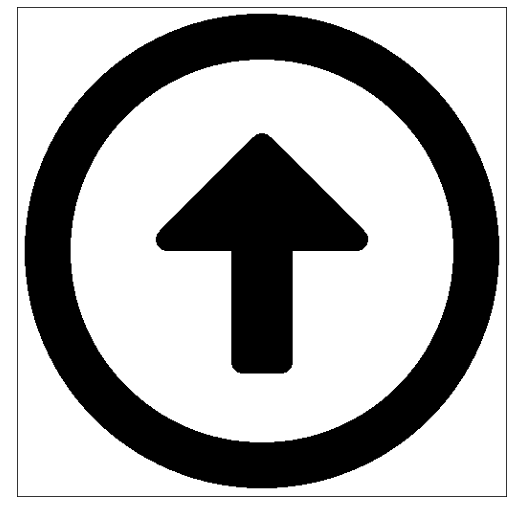

In [2]:
img = img_to_bw(data_dir + 'up.png', data_dir + 'up_bw.png')
show_grayscale_img(img)

Now we can load the binary image and generate samples from it as described in the assignment sheet.

Our image format is 512 x 512.


(0.0, 512.0)

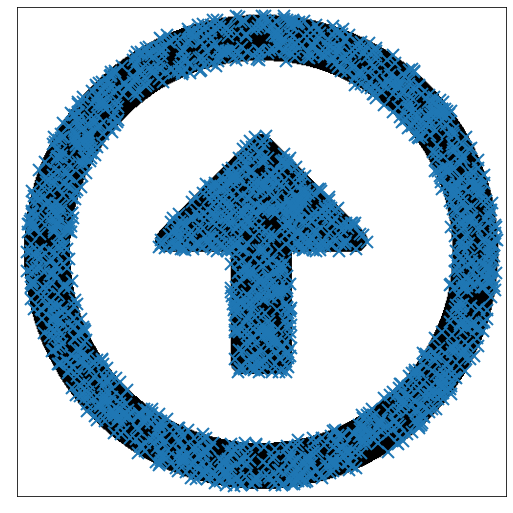

In [3]:
# load image
img = load_image(data_dir + 'up_bw.png')
height, width = img.shape
print(f'Our image format is {width} x {height}.')

# generate training samples
n_samples = 2000 # number of samples to generate
data = np.zeros((n_samples, 2))
rng = np.random.default_rng(seed=0)
i=0
while i < n_samples:
    row = rng.integers(0, height)
    col = rng.integers(0, width)
    if img[row, col] == 0:
        data[i,0] = col
        data[i,1] = row
        i += 1

# plot image with generated samples
show_grayscale_img(img)
plt.plot(data[:,0], data[:,1], 'x')
plt.xlim([0, width])
plt.ylim([0, height])

Train your flow here.

### Task a) Implement a coupling flow (spline coupling flow)

In [4]:
input_dim = 2
count_bins= 32
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
hidden_dims = [input_dim * 30, input_dim * 30]
transform = T.spline_coupling(input_dim=input_dim, count_bins=count_bins, hidden_dims=hidden_dims)
flow_dist = dist.TransformedDistribution(base_dist, [transform])

In [5]:
steps = 2_000

dataset = torch.tensor(data/512, dtype=torch.float)
optimizer = torch.optim.Adam(transform.parameters(), lr=1e-2)

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.384216070175171
step: 500, loss: -0.7403906583786011
step: 1000, loss: -0.9219669699668884
step: 1500, loss: -0.8278665542602539
step: 2000, loss: -0.8830559253692627


Put your learned model to the test: generate and plot some test samples.

<Figure size 720x720 with 0 Axes>

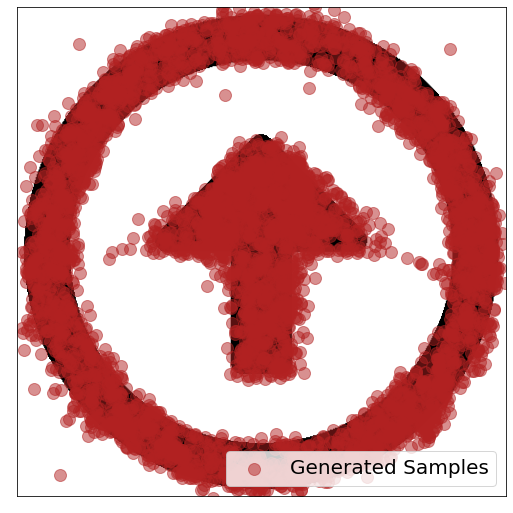

In [6]:
# generate samples from the learned distribution
samples = flow_dist.sample(torch.Size([5000,])).detach().numpy()
samples = samples*512

plt.close('all')
plt.figure(figsize=(10,10))
show_grayscale_img(img)
plt.scatter(samples[:,0], samples[:,1], color='firebrick', label='Generated Samples', alpha=0.5)
plt.xlim([0,512])
plt.ylim([0,512])
plt.legend()


We also want to have a look at the log-likelihood of our model!

Text(0, 0.5, 'Y')

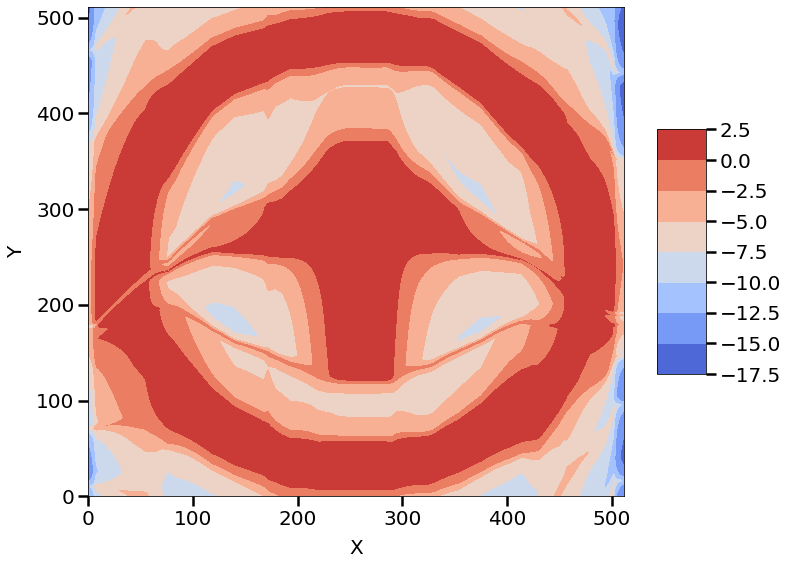

In [7]:
# compute the log-likelihood at a discrete grid
rows = np.arange(0, width)
cols = np.arange(0, height)
X, Y = np.meshgrid(cols, rows)

# flatten the grid points and evaluate their log-liklihoods
coordinates = torch.FloatTensor(np.stack((X,Y), axis=2)).view(-1, 2)
log_likelihood = flow_dist.log_prob(coordinates/width).detach().view(-1,width).numpy()

# finally, let's plot the log-likelihood
fig, ax = plt.subplots()
surf = ax.contourf(X, Y, log_likelihood, cmap=cm.coolwarm,  antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')


### Task b) Implement an autoregressive flow (spline autoregressive flow)

In [8]:
from pyro.nn import AutoRegressiveNN

input_dim = 2
count_bins = 32
base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
hidden_dims = [input_dim * 30, input_dim * 30]
param_dims = [count_bins, count_bins, count_bins - 1, count_bins]
hypernet = AutoRegressiveNN(input_dim, hidden_dims, param_dims=param_dims)
transform = T.SplineAutoregressive(input_dim, hypernet, count_bins=count_bins)
flow_dist = dist.TransformedDistribution(base_dist, [transform])

In [9]:
steps = 2_000

dataset = torch.tensor(data/512, dtype=torch.float)
#modules = torch.nn.ModuleList(transform)
optimizer = torch.optim.Adam(transform.parameters(), lr=1e-2)

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.3432562351226807
step: 500, loss: -0.8583347797393799
step: 1000, loss: -0.9545094966888428
step: 1500, loss: -0.9848714470863342
step: 2000, loss: -1.000016450881958


<Figure size 720x720 with 0 Axes>

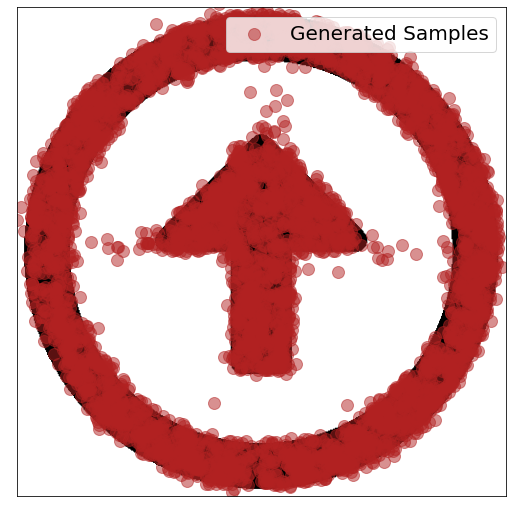

In [10]:
# generate samples from the learned distribution
samples = flow_dist.sample(torch.Size([5000,])).detach().numpy()
samples = samples*512

plt.close('all')
plt.figure(figsize=(10,10))
show_grayscale_img(img)
plt.scatter(samples[:,0], samples[:,1], color='firebrick', label='Generated Samples', alpha=0.5)
plt.xlim([0,512])
plt.ylim([0,512])
plt.legend()


Text(0, 0.5, 'Y')

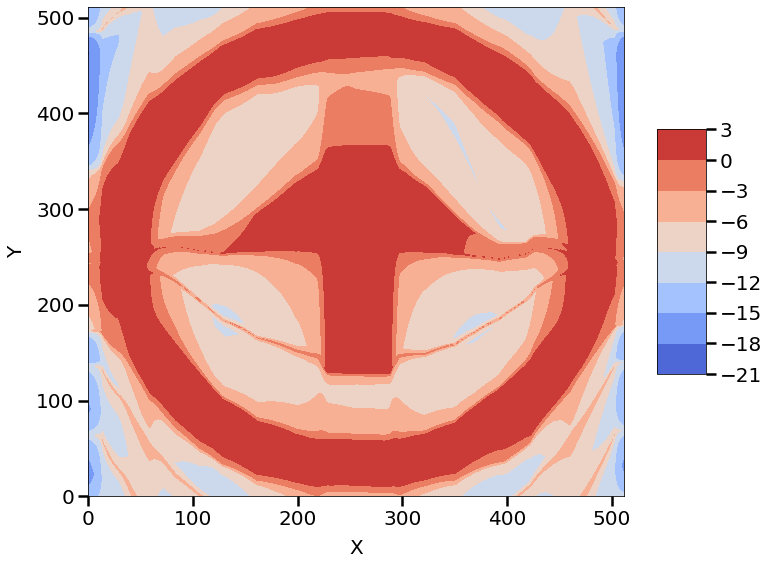

In [11]:
# compute the log-likelihood at a discrete grid
rows = np.arange(0, width)
cols = np.arange(0, height)
X, Y = np.meshgrid(cols, rows)

# flatten the grid points and evaluate their log-liklihoods
coordinates = torch.FloatTensor(np.stack((X,Y), axis=2)).view(-1, 2)
log_likelihood = flow_dist.log_prob(coordinates/width).detach().view(-1,width).numpy()

# finally, let's plot the log-likelihood
fig, ax = plt.subplots()
surf = ax.contourf(X, Y, log_likelihood, cmap=cm.coolwarm,  antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
